# Importing/Exporting field from/to `xarray.DataArray`

[`xarray`](https://docs.xarray.dev/en/stable/) provides a convenient method to handle *labeled* multi-dimensional arrays. It integrates well with `numpy` and `pandas` for fast array manipulation, as well as `matplotlib` for visualization. This makes it a good candidate to carry `discretisedfield.Field` data and additional metadata such as field name and unit (which appear in the plots rendered by `matplotlib`).

## Exporting `discretisedfield.Field` to `xarray.DataArray`

`to_xarray` method of the `discretisedfield.Field` object is utilized to export the field data to a DataArray.

In [1]:
import discretisedfield as df

p1 = (0, 0, 0)
p2 = (10e-9, 10e-9, 10e-9)
cell = (5e-9, 5e-9, 5e-9)

mesh = df.Mesh(p1=p1, p2=p2, cell=cell)
field = df.Field(mesh=mesh, dim=3, value=(0, 0, 1))
field

Field(Mesh(Region(p1=(0, 0, 0), p2=(1e-08, 1e-08, 1e-08)), n=(2, 2, 2), attributes: (unit: m, fourierspace: False, isplane: False)), dim=3, components: (x, y, z))

In [2]:
xarray = field.to_xarray()
xarray

<xarray.DataArray 'field' (x: 2, y: 2, z: 2, comp: 3)>
array([[[[0., 0., 1.],
         [0., 0., 1.]],

        [[0., 0., 1.],
         [0., 0., 1.]]],


       [[[0., 0., 1.],
         [0., 0., 1.]],

        [[0., 0., 1.],
         [0., 0., 1.]]]])
Coordinates:
  * x        (x) float64 2.5e-09 7.5e-09
  * y        (y) float64 2.5e-09 7.5e-09
  * z        (z) float64 2.5e-09 7.5e-09
  * comp     (comp) <U1 'x' 'y' 'z'
Attributes:
    units:    None
    cell:     (5e-09, 5e-09, 5e-09)
    p1:       (0, 0, 0)
    p2:       (1e-08, 1e-08, 1e-08)

The `DataArray` has four dimensions. Dimensions `x`, `y`, and `z` represents the geometric axes and their respective coordinates store the midpoints of cell edges along respective axes, while `comp` represents the components of the *field*. There will be no `comp` dimension if the stored field is a scalar field.

By default, the `DataArray` has four attributes, namely `units`, `cell`, `p1`, and `p2`. The last three attributes store the information about the mesh, and they prove useful for mesh reconstruction [from a `DataArray`](#from_xarray) object. The `units` attribute stores the unit of the field.  

By default, the DataArray name is `'field'` and `units` attribute is `None`. This can be set by passing the `to_xarray` method with `name` and `units` arguments.

In [3]:
xarray_2 = field.to_xarray(name='m', units='A/m')
print(f"Name of the DataArray is {xarray_2.name}.")
print(f"Units of the DataArray is {xarray_2.attrs['units']}.")

Name of the DataArray is m.
Units of the DataArray is A/m.


### Few useful `xarray.DataArray` methods

The underlying array can be accessed through:

In [8]:
xarray.values

array([[[[0., 0., 1.],
         [0., 0., 1.]],

        [[0., 0., 1.],
         [0., 0., 1.]]],


       [[[0., 0., 1.],
         [0., 0., 1.]],

        [[0., 0., 1.],
         [0., 0., 1.]]]])

It is possible to select the cross-section of the magnetization along a particular axis as:

In [9]:
xarray.sel(x=2e-9, method="nearest")

<xarray.DataArray 'field' (y: 2, z: 2, comp: 3)>
array([[[0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.]]])
Coordinates:
    x        float64 2.5e-09
  * y        (y) float64 2.5e-09 7.5e-09
  * z        (z) float64 2.5e-09 7.5e-09
  * comp     (comp) <U1 'x' 'y' 'z'
Attributes:
    units:    None
    cell:     (5e-09, 5e-09, 5e-09)
    p1:       (0, 0, 0)
    p2:       (1e-08, 1e-08, 1e-08)

The `DataArray.sel` method returns a new `DataArray` with only one coordinate along x-axis and hence a cross-section. The `method="nearest"` argument matches the value along x-axis with the nearest midpoint.

Similarly, one can also obtain a desired component of the field as:

In [10]:
xarray.sel(comp='z')

<xarray.DataArray 'field' (x: 2, y: 2, z: 2)>
array([[[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]]])
Coordinates:
  * x        (x) float64 2.5e-09 7.5e-09
  * y        (y) float64 2.5e-09 7.5e-09
  * z        (z) float64 2.5e-09 7.5e-09
    comp     <U1 'z'
Attributes:
    units:    None
    cell:     (5e-09, 5e-09, 5e-09)
    p1:       (0, 0, 0)
    p2:       (1e-08, 1e-08, 1e-08)

One can take this a step forward and obtain a new `DataArray` representing z component of the field on an x-axis cross-section of the geometry.

In [11]:
xarray.sel(comp='z').sel(x=2e-9, method="nearest")

<xarray.DataArray 'field' (y: 2, z: 2)>
array([[1., 1.],
       [1., 1.]])
Coordinates:
    x        float64 2.5e-09
  * y        (y) float64 2.5e-09 7.5e-09
  * z        (z) float64 2.5e-09 7.5e-09
    comp     <U1 'z'
Attributes:
    units:    None
    cell:     (5e-09, 5e-09, 5e-09)
    p1:       (0, 0, 0)
    p2:       (1e-08, 1e-08, 1e-08)

One can also plot the above `DataArray` as:

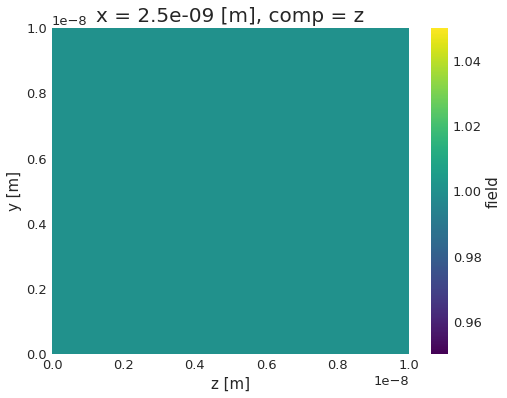

In [12]:
xarray.sel(comp='z').sel(x=2e-9, method="nearest").plot()

Notice that proper units and labels on the plot are displayed by default. The full list of `xarray.DataArray` methods can be found in the [API reference](https://docs.xarray.dev/en/stable/api.html).

### `to_xarray` exceptions

The `to_xarray` method raises `TypeError` if either `name` or `units` arguments are not strings.

In [14]:
field.to_xarray(name=3, units='A/m')

TypeError: Name argument must be a string.

In [15]:
field.to_xarray(name='m', units=1e8)

TypeError: Units argument must be a string.

<a id='from_xarray'></a>
## Importing `discretisedfield.Field` from `xarray.DataArray`

It is possible to create a `discretisedfield.Field` from an `xarray.DataArray` with the help of class method `from_xarray`. As a first step, we convert the `xarray.DataArray` created by `to_xarray` method to a new `discretisedfield.Field`.

In [17]:
field_new = df.Field.from_xarray(xarray)
field_new

Field(Mesh(Region(p1=(0, 0, 0), p2=(1e-08, 1e-08, 1e-08)), n=(2, 2, 2), attributes: (unit: m, fourierspace: False, isplane: False)), dim=3, components: (x, y, z))

One can also first define an `xarray.DataArray` and then convert it to `discretisedfield.Field`.

In [21]:
import numpy as np
import xarray as xr

xdr = xr.DataArray(np.ones((2, 2, 2, 3), dtype=float),
                   dims = ['x', 'y', 'z', 'comp'],
                   coords = dict(x=np.arange(2.5e-9, 1e-8, 5e-9),
                                 y=np.arange(2.5e-9, 1e-8, 5e-9),
                                 z=np.arange(2.5e-9, 1e-8, 5e-9),
                                 comp=['x', 'y', 'z']),
                   name = 'mag',
                   attrs = dict(cell=[5e-9, 5e-9, 5e-9],
                                p1=[0., 0., 0.],
                                p2=[1e-8, 1e-8, 1e-8]))
xdr

<xarray.DataArray 'mag' (x: 2, y: 2, z: 2, comp: 3)>
array([[[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]]])
Coordinates:
  * x        (x) float64 2.5e-09 7.5e-09
  * y        (y) float64 2.5e-09 7.5e-09
  * z        (z) float64 2.5e-09 7.5e-09
  * comp     (comp) <U1 'x' 'y' 'z'
Attributes:
    cell:     [5e-09, 5e-09, 5e-09]
    p1:       [0.0, 0.0, 0.0]
    p2:       [1e-08, 1e-08, 1e-08]

In [22]:
field_xdr = df.Field.from_xarray(xdr)
field_xdr

Field(Mesh(Region(p1=(0.0, 0.0, 0.0), p2=(1e-08, 1e-08, 1e-08)), n=(2, 2, 2), attributes: (unit: m, fourierspace: False, isplane: False)), dim=3, components: (x, y, z))

### `from_xarray` exceptions and expected properties of input `xarray.DataArray`

The input argument of `from_xarray` must be an `xarray.DataArray`. If not, a `TypeError` is raised.

In [23]:
df.Field.from_xarray(np.ones((2, 2, 2, 3), dtype=float))

TypeError: Argument must be a xr.DataArray.

The dimensions of the input `DataArray` must be either three or four depending on whether the field is scalar or vector. If not, a `ValueError` is raised.

In [25]:
bad_dim_no = xr.DataArray(np.ones((20, 20, 20, 5, 3), dtype=float),
                          dims=['x', 'y', 'z', 'a', 'comp'],
                          coords=dict(x=np.arange(0, 20),
                                      y=np.arange(0, 20),
                                      z=np.arange(0, 20),
                                      a=np.arange(0, 5),
                                      comp=['x', 'y', 'z']),
                          name='mag',
                          attrs=dict(units='A/m'))

df.Field.from_xarray(bad_dim_no)

ValueError: DataArray dimensions must be 3 for a scalar and 4 for a vector field.

Further the name of the dimensions must be `x`, `y`, `z`, and `comp` (if a vector field). If not, a `ValueError` is raised.

In [26]:
bad_dim_names = xr.DataArray(np.ones((20, 20, 5, 3), dtype=float),
                             dims=['x', 'y', 'z', 'c'],
                             coords=dict(x=np.arange(0, 20),
                                         y=np.arange(0, 20),
                                         z=np.arange(0, 5),
                                         c=['x', 'y', 'z']),
                             name='mag',
                             attrs=dict(units='A/m'))

df.Field.from_xarray(bad_dim_names)

ValueError: The dimensions must be 'x', 'y', 'z',and 'comp'.

The coordinates of the `x`, `y`, and `z` dimensions must be equally spaced. If not, a `ValueError` is raised.

In [27]:
rng = np.random.default_rng()

bad_spacing = xr.DataArray(np.ones((20, 20, 20, 3), dtype=float),
                           dims=['x', 'y', 'z', 'comp'],
                           coords=dict(x=rng.normal(size=20),
                                       y=np.arange(0, 20),
                                       z=np.arange(0, 20)),
                           name='mag',
                           attrs=dict(units='A/m'))

df.Field.from_xarray(bad_spacing)

ValueError: Coordinates of x must be equally spaced.

Lastly, **it is strongly advised that the input `xarray.DataArray` should have `p1`, `p2`, and `cell` attributes** required for the reconstruction of the mesh.